# 蠟燭線回測
### 初始資料拿取

In [2]:
import numpy as np
import pandas as pd
from talib import abstract
from finlab.data import Data

%matplotlib inline

data = Data()

signal = data.talib('CDLTRISTAR')

close = data.get_adj('收盤價')
open_ = data.get_adj('開盤價')

D:\Finlab\用 Python 理財：打造自己的 AI 股票理專\finlab\data.py:103: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  all_index = (df.index | item.index).sort_values()
D:\Finlab\用 Python 理財：打造自己的 AI 股票理專\finlab\data.py:103: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  all_index = (df.index | item.index).sort_values()
D:\Finlab\用 Python 理財：打造自己的 AI 股票理專\finlab\data.py:103: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  all_index = (df.index | item.index).sort_values()
D:\Finlab\用 Python 理財：打造自己的 AI 股票理專\finlab\data.py:103: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will

### 計算買入時間

In [3]:
sids = close.columns[:10]

signal = signal[sids]
close = close[sids]
open_ = open_[sids]

<AxesSubplot:xlabel='date'>

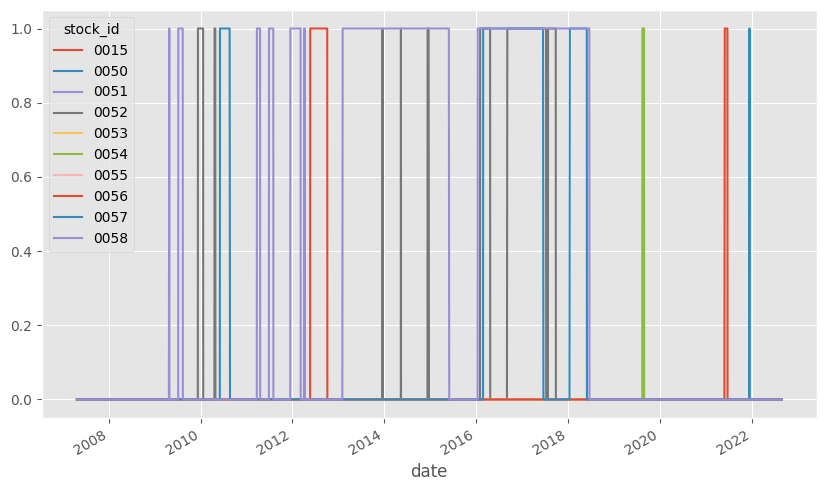

In [4]:
buy = (signal > 0)
sell = close < close.rolling(20).mean()
    
hold = pd.DataFrame(np.nan, index=close.index, columns=close.columns)
hold[buy] = 1
hold[sell] = 0
hold.ffill(inplace=True)
hold.fillna(0, inplace=True)
hold = hold.shift()

import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 6)
hold.plot()

### 計算報酬率

<AxesSubplot:xlabel='date'>

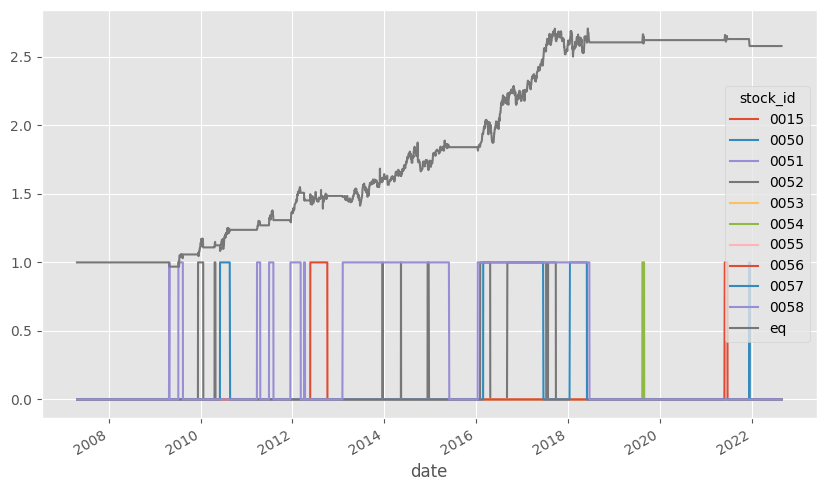

In [5]:
import matplotlib.pyplot as plt

gain = open_.shift(-1).ffill()[sids] / open_.ffill()[sids]
eq = (gain[hold == 1].mean(axis=1)).fillna(1).cumprod()

draw_df = hold.copy()
draw_df['eq'] = eq

draw_df.plot()

### 不要每天都rebalance

2.249004355546301

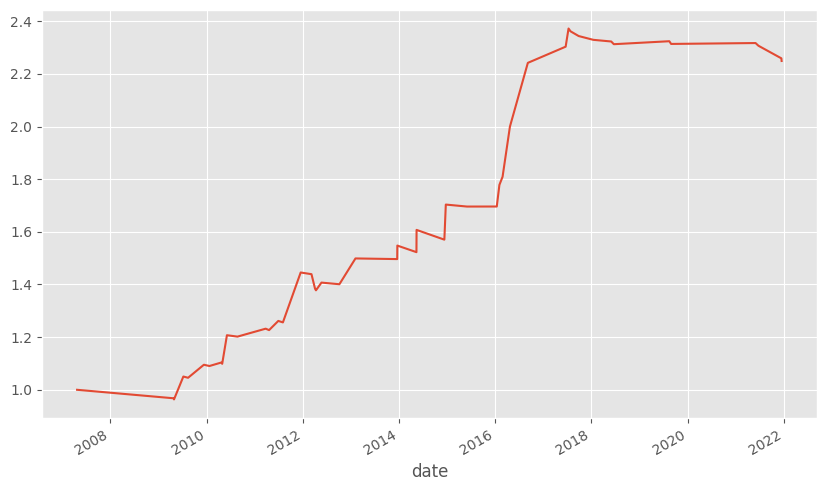

In [6]:
rebalance = (hold.diff().abs().sum(axis=1) != 0).cumsum()
rebalance_hold = hold[rebalance.diff() != 0]
rebalance_gain = gain.groupby(rebalance.values).apply(lambda s:s.cumprod().iloc[-1])
rebalance_gain.index = rebalance_hold.index

# 手續費
position_diff = rebalance_hold.div(rebalance_hold.sum(axis=1), axis=0).fillna(0).diff()
tax_ratio = position_diff.copy()
tax_ratio[tax_ratio < 0] *= (1.425/1000 + 3/1000)
tax_ratio[tax_ratio > 0] *= (1.425/1000)
tax_ratio = tax_ratio.abs().sum(axis=1)


eq2 = (rebalance_gain[rebalance_hold == 1].mean(axis=1).fillna(1) * (1 - tax_ratio)).cumprod()
eq2.plot()
eq2.iloc[-1]

## 考慮手續費

In [8]:
##http://finlabcourse.imotor.com/viewthread.php?tid=649&extra=page%3D1
s0050 = close['0050'].pct_change()
eq2 = eq2.reindex(s0050.index)

In [9]:
import pickle
pickle.dump(eq, open('return_history.pkl', 'wb'))